In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_validate
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

#We may want these at some point for transforming our output:
#from scipy.special import logit, expit

pd.set_option('display.max_columns', None) #forces all columns to be displayed
pd.set_option('display.max_rows', None) #forces all rows to be displayed

In [2]:
filepath = r'../data/data-reduced-train.csv'
data = pd.read_csv(filepath)

In [3]:
print(data['% Asian'].median())
print(data['% Black'].median())
print(data['% Hispanic'].median())
print(data['% Non-Hispanic White'].median())

0.8228077475
2.3496015596
5.1144083918
82.017880124


In [4]:
percent_white_median = data['% Non-Hispanic White'].median()

In [5]:
supermedian_white_counties = data[data['% Non-Hispanic White'] > percent_white_median]
submedian_white_counties = data[data['% Non-Hispanic White'] <= percent_white_median]

In [6]:
%run ../data/features-grouped.ipynb
%run ../data/model-information.ipynb

In [7]:
features = data.columns[4:].to_list()
target = data.columns[3] #'% Adults with Diabetes'

### Run XGB with optimized hyperparameters on the counties with white population above the median.
#### Cross validate to check performance

In [8]:
df = supermedian_white_counties.copy()
df_train, df_val = train_test_split(df, test_size=0.1, random_state=42)

def model_rmse(model, df, features, target):
    model_preds = model.predict(df[features])
    return root_mean_squared_error(df[target], model_preds)

params = xgb_best_params_full
n_neighbors = 10 #neighbors for kNN imputation
xgb_pipe = Pipeline([('impute', KNNImputer(n_neighbors=n_neighbors)),
                     ('xgb', XGBRegressor(**params))])

xgb_pipe.fit(df_train[features], df_train[target])

train_rmse = float(model_rmse(xgb_pipe, df_train, features, target))
val_rmse = float(model_rmse(xgb_pipe, df_val, features, target))

print(f'Training RMSE: {train_rmse:.4f}')
print(f'Validation RMSE: {val_rmse:.4f}')

Training RMSE: 0.1732
Validation RMSE: 0.4052


### Feature Importances from this model

In [9]:
category_colors = {
    "Health Behaviors": "skyblue",
    "Access to Care": "lightcoral",
    "Socio-economic Factors": "gold",
    "Physical Environment": "lightpink",
    "Demographics": "lightseagreen"
}

feature_to_category = {}
for category, feature_list in features_by_category.items():
    for feature in feature_list:
        feature_to_category[feature] = category

In [10]:
xgb_pipe = Pipeline([('impute', KNNImputer(n_neighbors=n_neighbors)),
                     ('xgb', XGBRegressor(**params))])

def get_sorted_model_importance_frame(model, df, features, target):
   model.fit(df[features], df[target])

   importances = model['xgb'].feature_importances_
   return pd.DataFrame({'Feature': features,
                               'importance_score': importances})\
                                .sort_values(by='importance_score', ascending=False)

def plot_top_model_importances(importance_frame, top_n=10):
   importance_frame['Category'] = importance_frame['Feature'].map(feature_to_category)
   importance_frame['Color'] = importance_frame['Category'].map(category_colors)

   #This function assumes the frame is already sorted by importance score, in descending order
   top_importances = importance_frame.head(top_n)

   plt.figure(figsize=(10,10))
   sns.barplot(data=top_importances, y='Feature', x='importance_score', orient='h', hue='Category', palette=category_colors)
   plt.xlabel('Feature Importance')
   plt.title('Feature Importances High White Counties')
   plt.tight_layout()
   plt.show()

In [11]:
# Re-trains model on the entire training subset of super-median counties
supermedian_white_importances = get_sorted_model_importance_frame(model = xgb_pipe, 
                                                                 df = supermedian_white_counties, 
                                                                 features=features, 
                                                                 target=target)

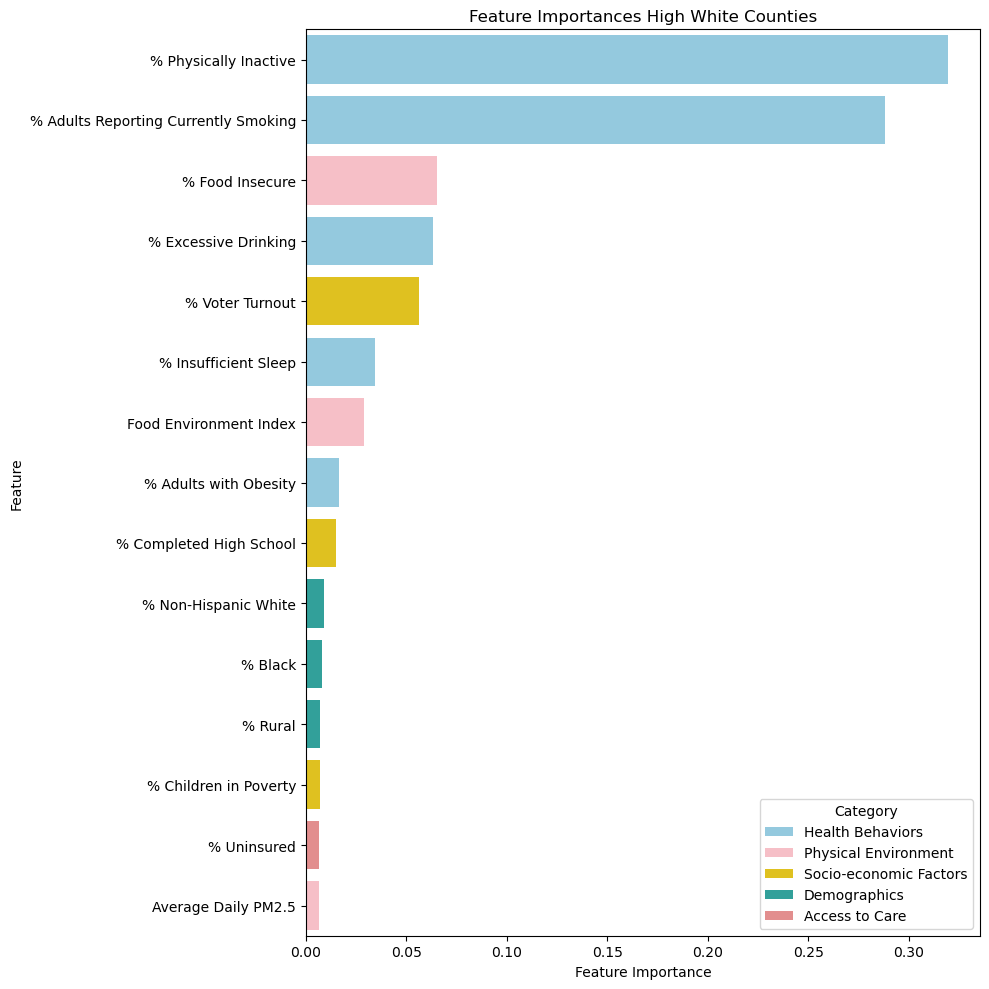

In [12]:
plot_top_model_importances(supermedian_white_importances, top_n=15)

### Same parameters fit to the sub-median White population counties

In [14]:
df = submedian_white_counties.copy()
df_train, df_val = train_test_split(df, test_size=0.1, random_state=42)

def model_rmse(model, df, features, target):
    model_preds = model.predict(df[features])
    return root_mean_squared_error(df[target], model_preds)

params = xgb_best_params_full
n_neighbors = 10 #neighbors for kNN imputation
xgb_pipe = Pipeline([('impute', KNNImputer(n_neighbors=n_neighbors)),
                     ('xgb', XGBRegressor(**params))])

xgb_pipe.fit(df_train[features], df_train[target])

train_rmse = float(model_rmse(xgb_pipe, df_train, features, target))
val_rmse = float(model_rmse(xgb_pipe, df_val, features, target))

print(f'Training RMSE: {train_rmse:.4f}')
print(f'Validation RMSE: {val_rmse:.4f}')

Training RMSE: 0.2340
Validation RMSE: 0.5944


In [ ]:
model = Pipeline([('impute', KNNImputer(n_neighbors=n_neighbors)),
                     ('xgb', XGBRegressor(**params))])

#Trains the model on all the submedian counties in the training set
submedian_white_importances = get_sorted_model_importance_frame(model, submedian_white_counties, features, target)

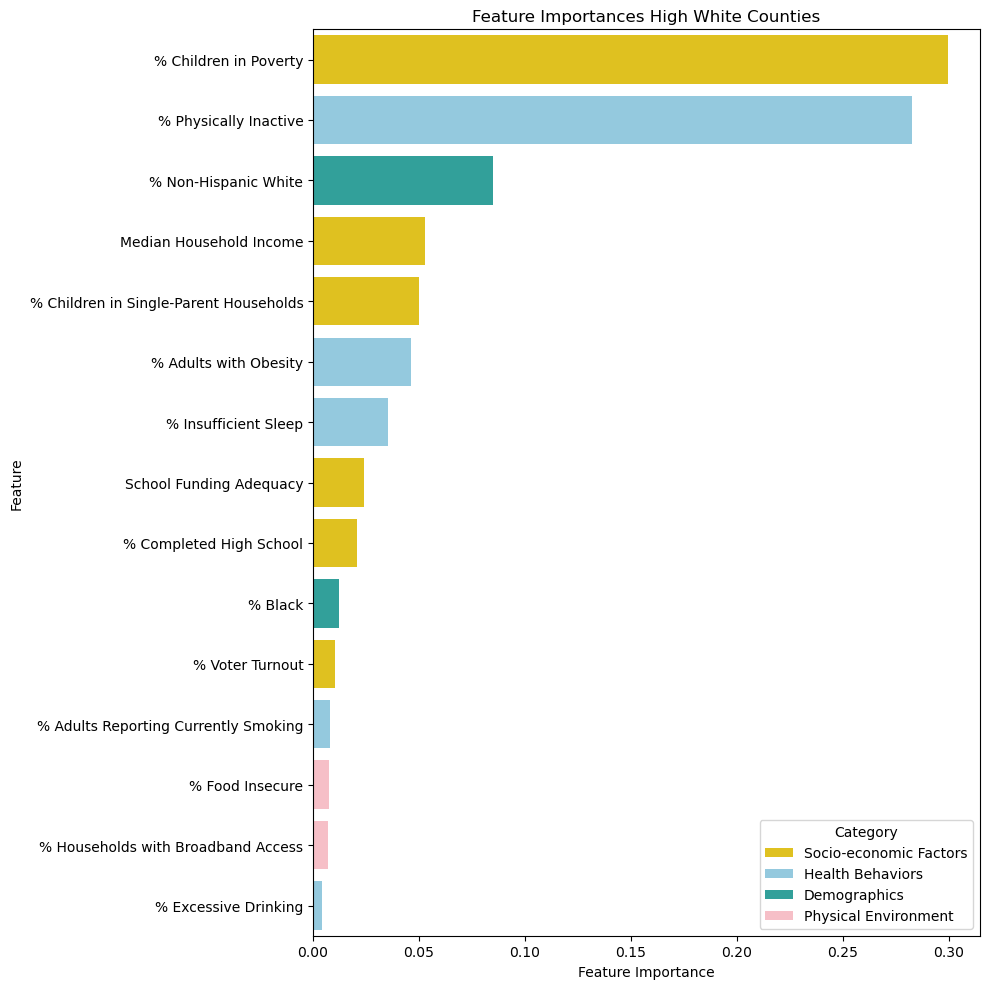

In [ ]:
#plots the top model importances from the previous cell
plot_top_model_importances(submedian_white_importances, top_n=15)